In [38]:
import os
import numpy as np
from sklearn.cluster import MeanShift
from pathlib import Path
from matplotlib import pyplot as plt
import time
from skimage.segmentation import felzenszwalb
from skimage.color import gray2rgb

In [39]:
os.environ["OPENCV_IO_ENABLE_OPENEXR"]="1"
import cv2

In [64]:
# Load depth image and normalize it
depth_path = Path("input/01396.exr")
depth_im = cv2.imread(str(depth_path), cv2.IMREAD_ANYDEPTH)

max_mask = depth_im < 0.5
min_mask = depth_im > 0.1

mask =  max_mask * min_mask

maksed_depth_image = mask * depth_im


# mask_threshold[mask] = 1
# mask_threshold[~mask] = 0


# You might want to mask the depth image based on the target object's depth here
norm_depth_im = (255.0 * depth_im / depth_im.max()).astype(np.uint8)
norm_masked_depth_im = (255.0 * maksed_depth_image / maksed_depth_image.max()).astype(np.uint8)


[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102]
[  0 102]


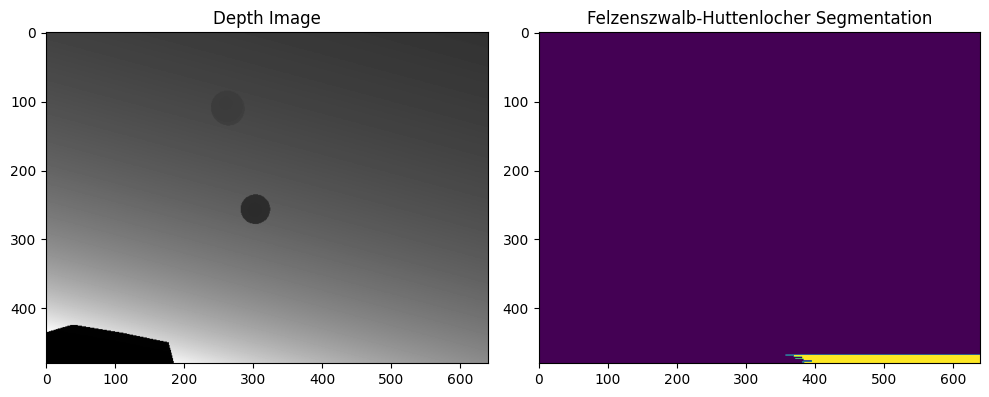

In [75]:
depth_3channel = gray2rgb(norm_depth_im)
segments = felzenszwalb(depth_3channel, scale=100, sigma=1, min_size=50)
unique_labels = np.unique(segments)
print(unique_labels)
segments = segments * mask
unique_labels = np.unique(segments)
print(unique_labels)
segment_masks = []

for label in unique_labels:
    mask = (segments == label)
    segment_masks.append(mask)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].imshow(norm_depth_im, cmap='gray')
ax[0].set_title('Depth Image')

ax[1].imshow(segments, cmap='viridis')
ax[1].set_title('Felzenszwalb-Huttenlocher Segmentation')

plt.tight_layout()
plt.show()

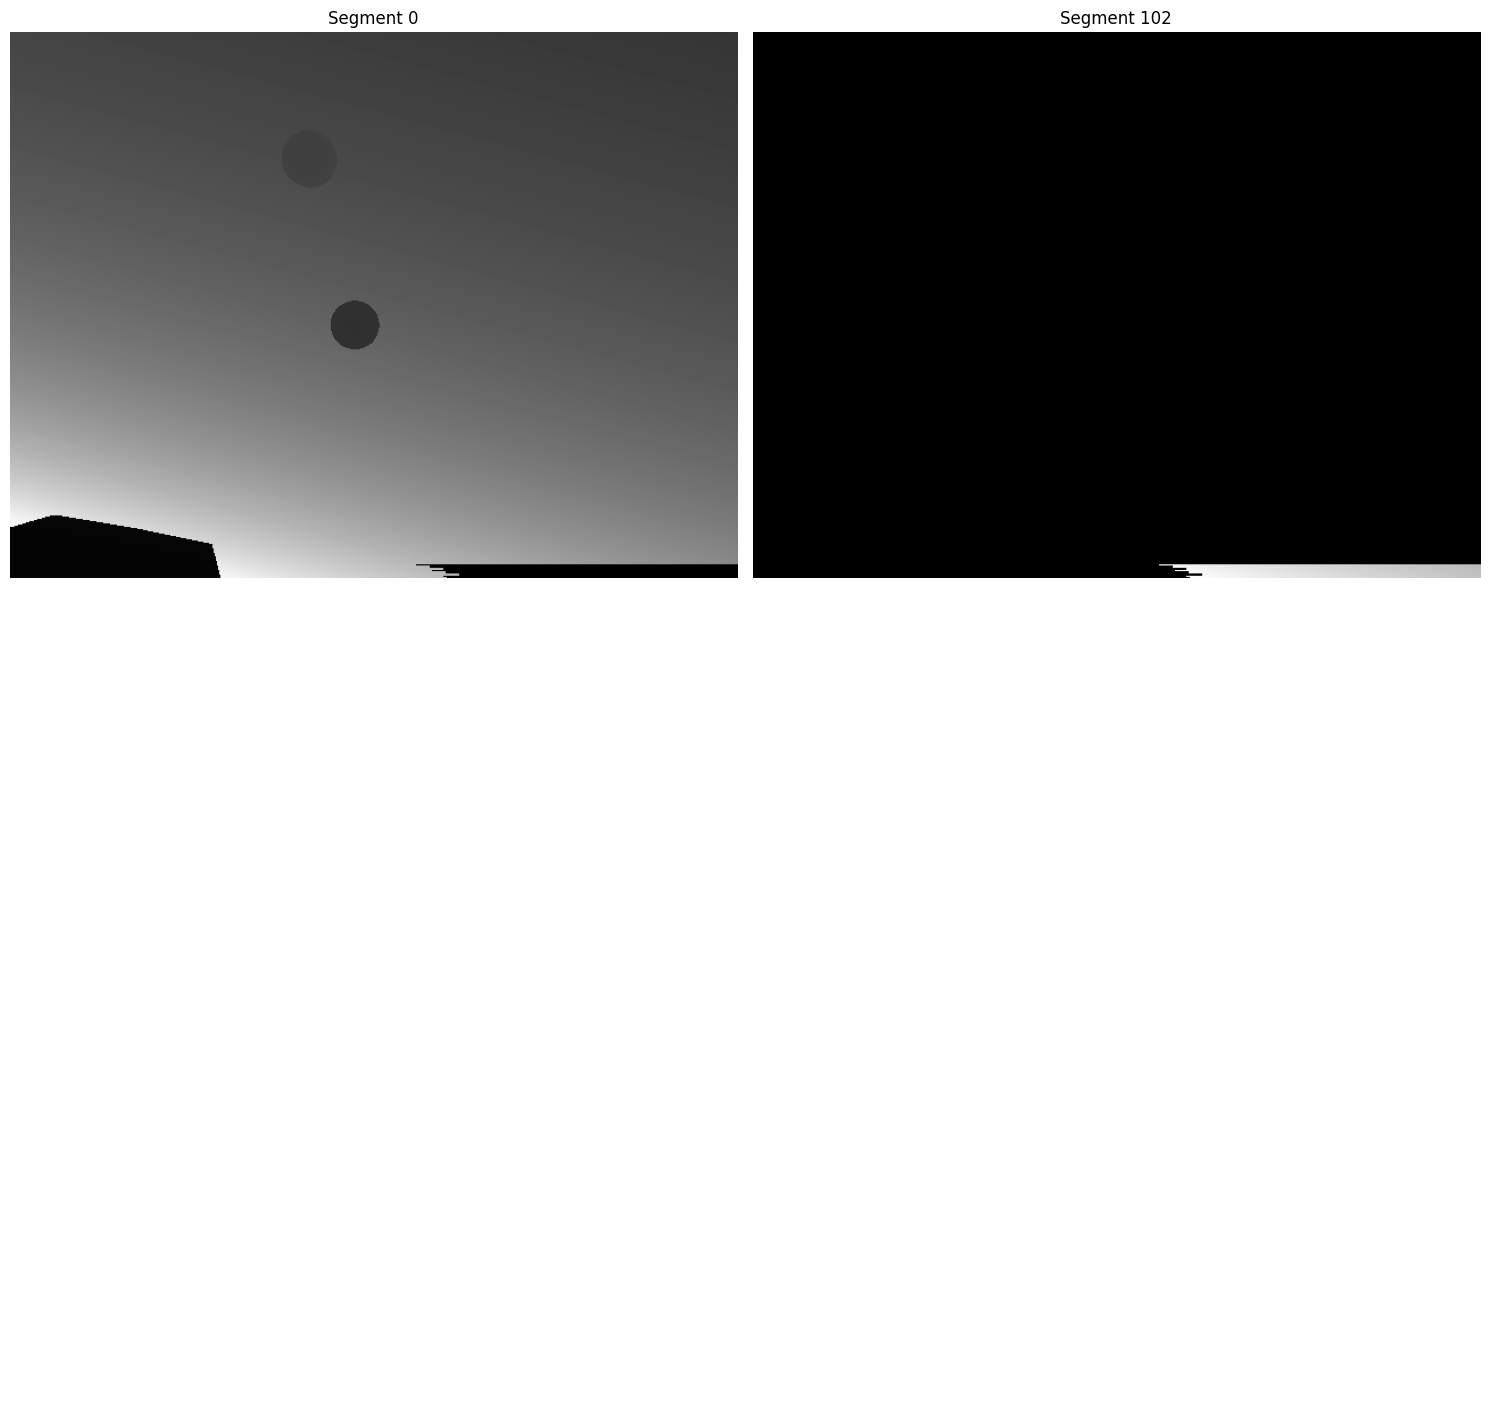

In [76]:

# Determine the number of rows and columns for the subplot grid
n_rows = int(np.ceil(np.sqrt(len(unique_labels))))
n_cols = n_rows

# Create a figure and axes with the desired number of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))

# Initialize all subplots as blank
for ax in axes.ravel():
    ax.axis('off')

# Iterate through the unique labels and their corresponding segment masks
for i, (label, mask) in enumerate(zip(unique_labels, segment_masks)):
    # Create a masked image by applying the mask to the depth_image
    masked_image = depth_im.copy()
    masked_image[~mask] = 0

    # Calculate the current row and column of the subplot
    row, col = divmod(i, n_cols)

    # Display the masked image in the corresponding subplot
    axes[row, col].imshow(masked_image, cmap='gray')
    axes[row, col].set_title(f"Segment {label}")
    axes[row, col].axis('off')

# Adjust subplot spacing and display the figure
plt.tight_layout()
plt.show()

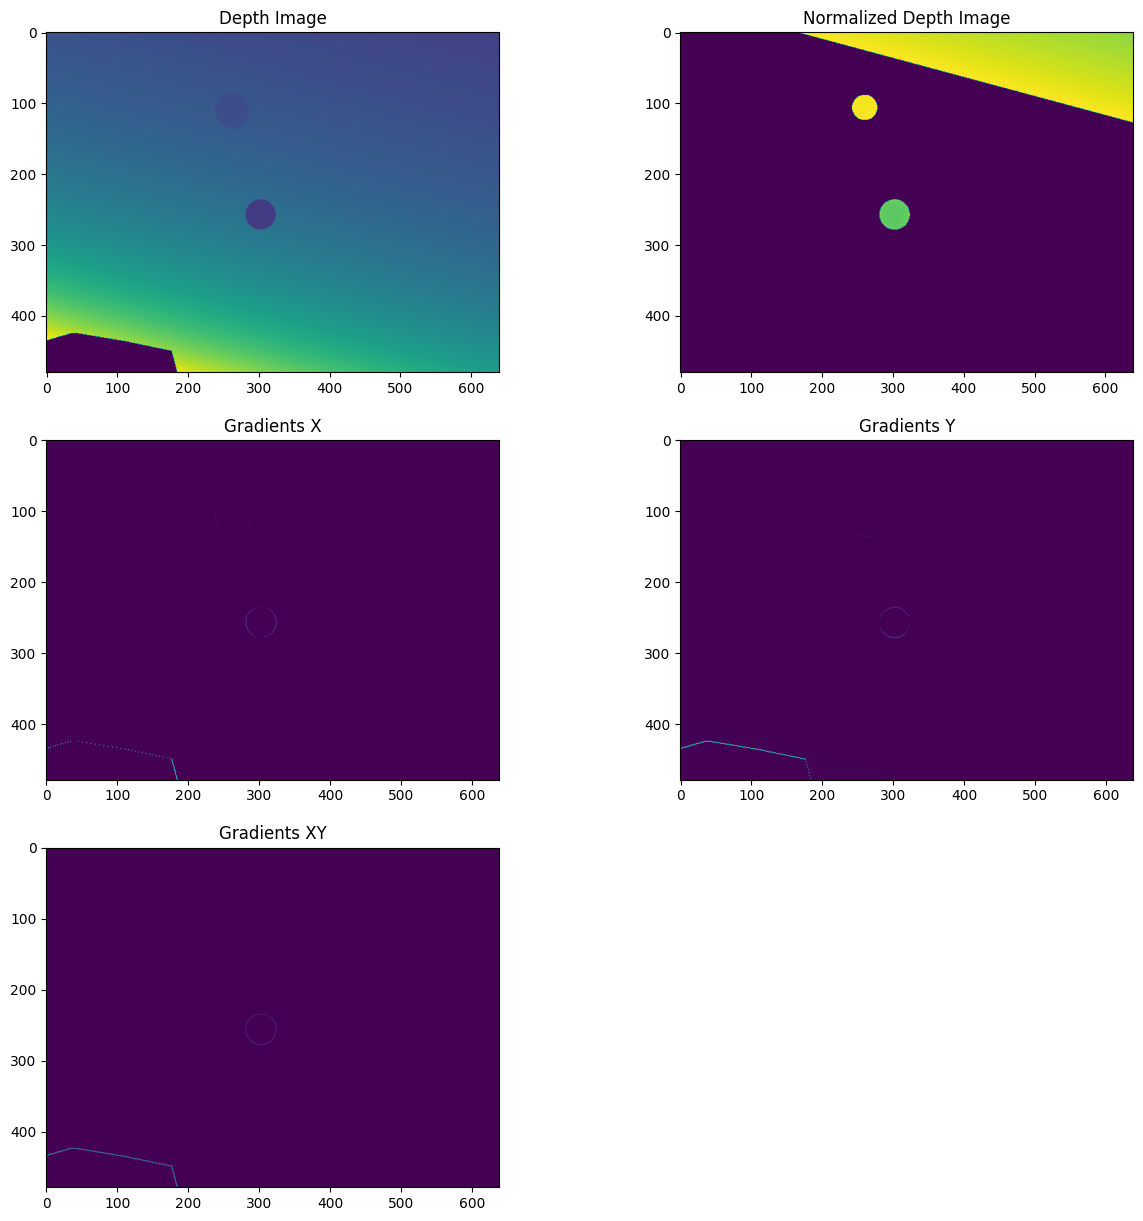

In [63]:

# Compute gradients along X and Y axes
dx = np.abs(depth_im[1:, 1:] - depth_im[1:, :-1])
dy = np.abs(depth_im[1:, 1:] - depth_im[:-1, 1:])
dxy = dx + dy
dxyn = (255 * dxy / dxy.max()).astype(np.uint8)

# Visualize computed images
rows = 3
cols = 2
plt.rcParams["figure.figsize"]=15,15

plt.subplot(rows, cols, 1)
plt.title("Depth Image")
plt.imshow(depth_im.astype('float'))

plt.subplot(rows, cols, 2)
plt.title("Normalized Depth Image")
plt.imshow(norm_depth_im)

plt.subplot(rows, cols, 3)
plt.title("Gradients X")
plt.imshow(dx / dx.max())

plt.subplot(rows, cols, 4)
plt.title("Gradients Y")
plt.imshow(dy / dy.max())

plt.subplot(rows, cols, 5)
plt.title("Gradients XY")
plt.imshow(dxyn)

Computation took 13.43ms


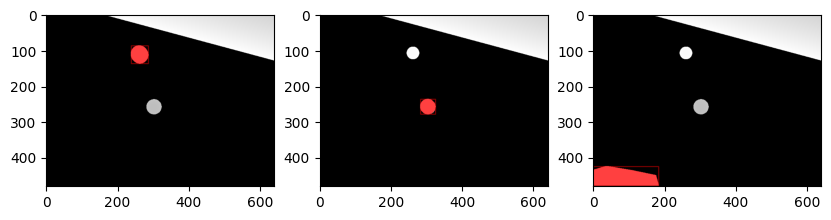

In [62]:
# Compute maximally stable extremal regions in gradient image
start = time.time()
mser = cv2.MSER.create(delta = 1)
msers, bboxes = mser.detectRegions(dxyn)
end = time.time()
print(f"Computation took {1000.0 * (end - start):.2f}ms")

# Visualize detected regions (bounding box and mask)
rows = int(len(msers) / 3 + 1)
plt.rcParams["figure.figsize"]=rows*5,15
for i, bbox in enumerate(bboxes):
    plt.subplot(rows, 3, i+1)
    
    vis_im = np.tile(norm_depth_im.copy()[..., None], (1,1,3))
    cv2.rectangle(vis_im, bbox[:2], bbox[:2] + bbox[2:], [128, 0, 0], 2)
    for pt in msers[i]:
        vis_im = cv2.circle(vis_im, pt, 1, [255, 64, 64]);

    plt.imshow(vis_im)